In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, rankdata

In [2]:
# initialize parameter settings
parameter_names = ['N','p','K','size_ratio','eta']
parameter_names_display = [r'$n$',r'$p$',r'$K$',r'$\rho$',r'$\eta$'] # for matplotlib
parameter_values = [[1000,5000,10000, 1150],
                    [0.01,0.1,0.02,0.5,1],
                    [2, 3, 5, 4, 10, 20], 
                    [1.5, 1, 2],
                    [0, 0.05,0.1,0.15,0.2, 0.25,0.3, 0.35, 0.4, 0.45]]
parameter_dict = dict(zip(parameter_names, parameter_values))
compare_names = ['A','sns','dns','L','L_sym','BNC','BRC','SPONGE','SPONGE_sym','SSSNET']
compare_names_all = []
compare_names_all.extend(compare_names[:-1])

feature_options = ['A_reg']
feat_choice = '_'.join(feature_options)

for feat in feature_options:
    compare_names_all.append(compare_names[-1]+'_'+feat)
compare_names_all = compare_names
    
method_str = 'SpectralSSSNET'    

figure_markers = ['*','P','<','s','8','+','H','|','D','>','v','^','d']

hop=2
tau = 0.5
seed_ratio = 0.1
hidden = 32
lr = 0.01
train_ratio = 0.8
test_ratio = 0.1
alpha = 0
link_sign_loss = 0
link_sign_loss_ratio = 0.1
supervised_loss_ratio = 50
triplet_loss_ratio = 0.1
seeds = [10,20,30,40,50]

In [3]:
def SSBM_comparison_plot(K=2,p=0.1,size_ratio=1.5,N=200, eta=0.1, save=True):
    change_var_ind = -1
    change_parameter = 'eta'
    change_var_values = [0, 0.05,0.1,0.15,0.2, 0.25,0.3,0.35,0.4, 0.45]
    var_name_display = r'$\eta$'
    default_values = [N, p,K,size_ratio,eta] # initialize default values
    # extract results
    results_mean = np.zeros([len(compare_names_all),len(change_var_values)])
    results_std = np.zeros([len(compare_names_all),len(change_var_values)])
    nmi_mean = np.zeros([len(compare_names_all),len(change_var_values)])
    nmi_std = np.zeros([len(compare_names_all),len(change_var_values)])

    all_not_found = True
    dir_name = '../0811result_arrays/SSBM/'
    
    for i, var in enumerate(change_var_values):
        file_not_found = True
        updated_values = default_values.copy()
        updated_values[-1] = var
        N, p,K,size_ratio,eta  = updated_values # update parameter settings
        param_values = [p,eta,K,N,hop,tau,size_ratio, seed_ratio, alpha, lr, 
                        hidden, triplet_loss_ratio, link_sign_loss, link_sign_loss_ratio, supervised_loss_ratio]
        result_save_name = '_'.join([str(int(100*value)) for value in param_values])+'_'+feat_choice+'_'+method_str
        result_save_name += 'seeds' + '_'.join([str(value) for value in np.array(seeds).flatten()])+'.npy'
        file_name = dir_name + 'test'+ result_save_name
        if os.path.exists(file_name):
            res = np.load(file_name)
            nmi = np.load(dir_name + 'test_NMI'+ result_save_name)
            all_not_found = False
            file_not_found = False
        if not file_not_found:
            results_mean[:,i] = np.nanmean(res, axis=0)
            results_std[:,i] = np.nanstd(res, axis=0)
            nmi_mean[:,i] = np.nanmean(nmi, axis=0)
            nmi_std[:,i] = np.nanstd(nmi, axis=0)
        else:
            print(result_save_name)
            results_mean[:,i] = np.nan
            results_std[:,i] = np.nan
            nmi_mean[:,i] = np.nan
            nmi_std[:,i] = np.nan

    save_name_base = result_save_name[:-4]+'Change_{}'.format(change_parameter)+'.pdf'
    dir_name = '../comparison_plots/0811results/'
    if os.path.isdir(dir_name) == False:
        try:
            os.makedirs(dir_name)
        except FileExistsError:
            print('Folder exists!')
    if all_not_found:
        # print("Plot empty."+save_name)
        return
    
    # ranking comparison
    ranking_kendalltau = np.zeros([len(change_var_values)])
    for i in range(len(change_var_values)):
        ranking_kendalltau[i], _ = kendalltau(rankdata(results_mean[:,i]), rankdata(nmi_mean[:,i]))
    print('KandallTau results are {} with mean {:.3f} and standard deviation {:.3f}.'.format(ranking_kendalltau, 
                                                                                             np.nanmean(ranking_kendalltau), 
                                                                                             np.nanstd(ranking_kendalltau)))
    
    # plot ARIs
    results_mean_mean = results_mean.mean(0)
    ind_all = np.arange(len(change_var_values))
    valid_ind = list(set(ind_all[results_mean_mean>0.01]).intersection(set(ind_all[results_mean_mean<0.99])))
    if len(valid_ind):
        start = max(0, min(valid_ind)-2)
        end = min(len(ind_all), max(valid_ind)+2)
        results_mean = results_mean[:,start:end]
        results_std = results_std[:,start:end]
        change_var_values = change_var_values[start:end]
    plt.figure(figsize=[8,6])
    plt.rcParams.update({'font.size': 23.5})
    change_var_values = np.array(change_var_values)
    if change_var_values.max()-change_var_values.min() > 0.3:
        plt.xticks(np.arange(change_var_values.min(),change_var_values.max()+0.1,step=0.1))
    else:
        plt.xticks(np.arange(change_var_values.min(),change_var_values.max()+0.05,step=0.05))
    for j in range(len(compare_names)-1):
        plt.errorbar(change_var_values, results_mean[j], yerr=results_std[j], label=compare_names_all[j],alpha=0.7, fmt=figure_markers[j], ls='None')
    for j in range(len(compare_names)-1,len(compare_names_all)):
        plt.errorbar(change_var_values, results_mean[j], yerr=results_std[j], label=compare_names_all[j],alpha=0.8, fmt=figure_markers[j%len(figure_markers)], ls='--')
    plt.xlabel(var_name_display,fontsize=22)
    positive_labelpad = np.sum(results_mean-results_std<-0.1) > 0
    plt.ylabel('ARI',fontsize=22,labelpad=-15*positive_labelpad)
    plt.rcParams.update({'font.size': 12})    
    title_name = 'SSBM '
    for i, def_var in enumerate(parameter_names_display):
        if i != (len(parameter_names_display) - 1):
            title_name = title_name + def_var + '={}.'.format(default_values[i])
    plt.title(title_name)
    if save:
        print('Saving figure!')
        save_name = dir_name + 'SSBM_ARI_'+save_name_base
        plt.savefig(save_name,format='pdf')
    plt.legend(loc='best',framealpha=0.0,fontsize=20)
    if save:
        print('Saving figure!')
        save_name = dir_name + 'legend_SSBM_ARI_'+save_name_base
        plt.savefig(save_name,format='pdf')
    plt.show()
    return ranking_kendalltau

### Comparison results

1_30_500_100000_200_50_150_10_0_1_3200_10_0_10_5000_A_reg_SpectralSSSNETseeds10_20_30_40_50.npy
1_35_500_100000_200_50_150_10_0_1_3200_10_0_10_5000_A_reg_SpectralSSSNETseeds10_20_30_40_50.npy
1_40_500_100000_200_50_150_10_0_1_3200_10_0_10_5000_A_reg_SpectralSSSNETseeds10_20_30_40_50.npy
1_45_500_100000_200_50_150_10_0_1_3200_10_0_10_5000_A_reg_SpectralSSSNETseeds10_20_30_40_50.npy
KandallTau results are [0.95555556 0.86666667 1.         0.42222222 0.73333333 0.73333333
 1.         1.         1.         1.        ] with mean 0.871 and standard deviation 0.182.
Saving figure!
Saving figure!


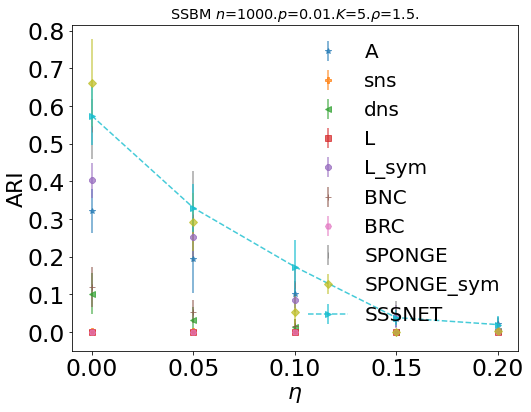

1_45_500_500000_200_50_150_10_0_1_3200_10_0_10_5000_A_reg_SpectralSSSNETseeds10_20_30_40_50.npy
KandallTau results are [1.         1.         1.         0.91111111 1.         0.95555556
 1.         0.91111111 0.86666667 1.        ] with mean 0.964 and standard deviation 0.048.
Saving figure!
Saving figure!


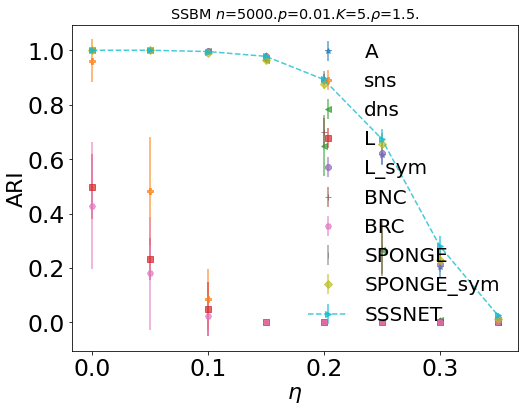

1_45_500_1000000_200_50_150_10_0_1_3200_10_0_10_5000_A_reg_SpectralSSSNETseeds10_20_30_40_50.npy
KandallTau results are [1.         1.         1.         1.         1.         0.95555556
 0.95555556 0.95555556 0.91111111 1.        ] with mean 0.978 and standard deviation 0.030.
Saving figure!
Saving figure!


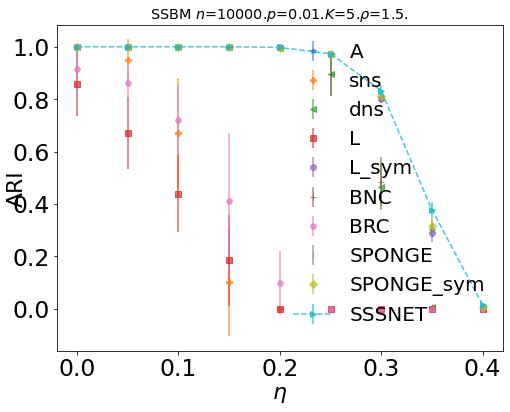

0_45_500_3000000_200_50_150_10_0_1_3200_10_0_10_5000_A_reg_SpectralSSSNETseeds10_20_30_40_50.npy
KandallTau results are [0.95555556 0.95555556 0.91111111 0.91111111 0.95555556 0.6
 0.72727273 0.73333333 0.0952381  1.        ] with mean 0.784 and standard deviation 0.261.
Saving figure!
Saving figure!


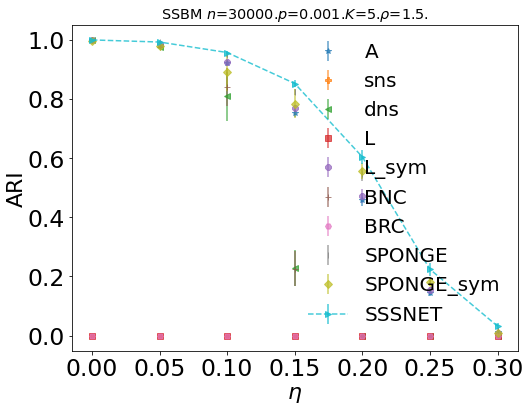

In [4]:
kendalltau_list = []
kendalltau_list.extend(SSBM_comparison_plot(K=5,p=0.01,eta=0.05,size_ratio=1.5,N=1000))
kendalltau_list.extend(SSBM_comparison_plot(K=5,p=0.01,eta=0.05,size_ratio=1.5,N=5000))
kendalltau_list.extend(SSBM_comparison_plot(K=5,p=0.01,eta=0.05,size_ratio=1.5,N=10000))
kendalltau_list.extend(SSBM_comparison_plot(K=5,p=0.001,eta=0.05,size_ratio=1.5,N=30000))

In [5]:
# initialize parameter settings for polazied SSBMs
parameter_names = ['total_n','p','num_com','size_ratio','eta']
parameter_names_display = [r'$n$',r'$p$',r'$N_{c}$',r'$\rho$',r'$\eta$'] # for matplotlib
parameter_values = [[1050,5000,10000, 1150],
                    [0.01,0.1,0.02,0.5,1],
                    [2, 3, 5, 4, 10, 20], 
                    [1.5, 1, 2],
                    [0, 0.05,0.1,0.15,0.2, 0.25,0.3, 0.35, 0.4, 0.45]]
parameter_dict = dict(zip(parameter_names, parameter_values))

In [6]:
def polarized_comparison_plot(total_n, num_com, K=2,p=0.1,size_ratio=1.5,N=200, eta=0.1, save=True):
    change_var_ind = -1
    change_parameter = 'eta'
    change_var_values = [0, 0.05,0.1,0.15,0.2, 0.25,0.3,0.35,0.4, 0.45]
    var_name_display = r'$\eta$'
    default_values = [total_n, p, num_com, size_ratio, eta] # initialize default values
    # extract results
    results_mean = np.zeros([len(compare_names_all),len(change_var_values)])
    results_std = np.zeros([len(compare_names_all),len(change_var_values)])
    nmi_mean = np.zeros([len(compare_names_all),len(change_var_values)])
    nmi_std = np.zeros([len(compare_names_all),len(change_var_values)])

    all_not_found = True
    dir_name = '../0811result_arrays/polarized/'
    
    for i, var in enumerate(change_var_values):
        updated_values = default_values.copy()
        updated_values[-1] = var
        total_n, p, num_com, size_ratio, eta  = updated_values # update parameter settings
        param_values = [total_n, num_com, p,eta,K,N,hop,tau,size_ratio, seed_ratio, alpha, lr, 
                        hidden, triplet_loss_ratio, link_sign_loss, link_sign_loss_ratio, supervised_loss_ratio]
        result_save_name = '_'.join([str(int(100*value)) for value in param_values])+'_'+feat_choice+'_'+method_str
        result_save_name += 'seeds' + '_'.join([str(value) for value in np.array(seeds).flatten()])+'.npy'
        file_name = dir_name + 'test'+ result_save_name
        if os.path.exists(file_name):
            res = np.load(file_name)
            nmi = np.load(dir_name + 'test_NMI'+ result_save_name)
            all_not_found = False
            file_not_found = False
        if not file_not_found:
            results_mean[:,i] = np.nanmean(res, axis=0)
            results_std[:,i] = np.nanstd(res, axis=0)
            nmi_mean[:,i] = np.nanmean(nmi, axis=0)
            nmi_std[:,i] = np.nanstd(nmi, axis=0)
        else:
            print(result_save_name)
            results_mean[:,i] = np.nan
            results_std[:,i] = np.nan
            nmi_mean[:,i] = np.nan
            nmi_std[:,i] = np.nan
        
        
    save_name_base = result_save_name[:-4]+'Change_{}'.format(change_parameter)+'.pdf'
    dir_name = '../comparison_plots/0811results/'
    if os.path.isdir(dir_name) == False:
        try:
            os.makedirs(dir_name)
        except FileExistsError:
            print('Folder exists!')
    if all_not_found:
        # print("Plot empty."+save_name)
        return
    # ranking comparison
    ranking_kendalltau = np.zeros([len(change_var_values)])
    for i in range(len(change_var_values)):
        ranking_kendalltau[i], _ = kendalltau(rankdata(results_mean[:,i]), rankdata(nmi_mean[:,i]))
    print('KandallTau results are {} with mean {:.3f} and standard deviation {:.3f}.'.format(ranking_kendalltau, 
                                                                                             np.nanmean(ranking_kendalltau), 
                                                                                             np.nanstd(ranking_kendalltau)))
    
    
    # plot ARIs
    results_mean_mean = results_mean.mean(0)
    ind_all = np.arange(len(change_var_values))
    valid_ind = list(set(ind_all[results_mean_mean>0.01]).intersection(set(ind_all[results_mean_mean<0.99])))
    if len(valid_ind):
        start = max(0, min(valid_ind)-2)
        end = min(len(ind_all), max(valid_ind)+2)
        results_mean = results_mean[:,start:end]
        results_std = results_std[:,start:end]
        change_var_values = change_var_values[start:end]
    plt.figure(figsize=[8,6])
    plt.rcParams.update({'font.size': 23.5})
    change_var_values = np.array(change_var_values)
    if change_var_values.max()-change_var_values.min() > 0.3:
        plt.xticks(np.arange(change_var_values.min(),change_var_values.max()+0.1,step=0.1))
    else:
        plt.xticks(np.arange(change_var_values.min(),change_var_values.max()+0.05,step=0.05))
    for j in range(len(compare_names)-1):
        plt.errorbar(change_var_values, results_mean[j], yerr=results_std[j], label=compare_names_all[j],alpha=0.7, fmt=figure_markers[j], ls='None')
    for j in range(len(compare_names)-1,len(compare_names_all)):
        plt.errorbar(change_var_values, results_mean[j], yerr=results_std[j], label=compare_names_all[j],alpha=0.8, fmt=figure_markers[j%len(figure_markers)], ls='--')
    plt.xlabel(var_name_display,fontsize=22)
    plt.ylabel('ARI',fontsize=22)
    plt.rcParams.update({'font.size': 12})    
    title_name = 'polarized '
    for i, def_var in enumerate(parameter_names_display):
        if i != (len(parameter_names_display) - 1):
            title_name = title_name + def_var + '={}.'.format(default_values[i])
    plt.title(title_name)
    if save:
        print('Saving figure!')
        save_name = dir_name + 'ARI_'+save_name_base
        plt.savefig(save_name,format='pdf')
    plt.legend(loc='best',framealpha=0.0,fontsize=18)
    if save:
        print('Saving figure!')
        save_name = dir_name + 'legend_polarized_ARI_'+save_name_base
        plt.savefig(save_name,format='pdf')
    plt.show()
    return ranking_kendalltau

KandallTau results are [1.         1.         0.91111111 0.91111111 0.73333333 0.42222222
 0.42222222 0.42222222 0.42222222 0.42222222] with mean 0.667 and standard deviation 0.254.
Saving figure!
Saving figure!


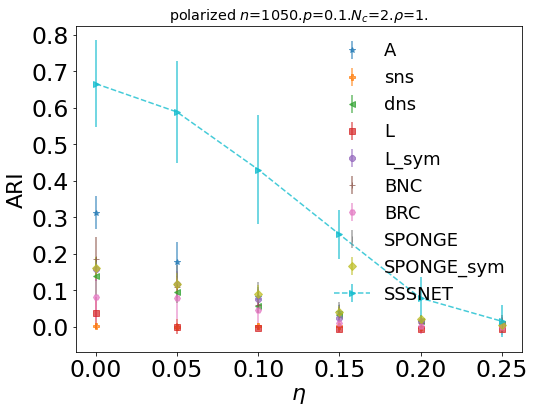

KandallTau results are [0.95555556 0.82222222 1.         0.68888889 0.55555556 0.55555556
 0.55555556 0.55555556 0.55555556 0.55555556] with mean 0.680 and standard deviation 0.171.
Saving figure!
Saving figure!


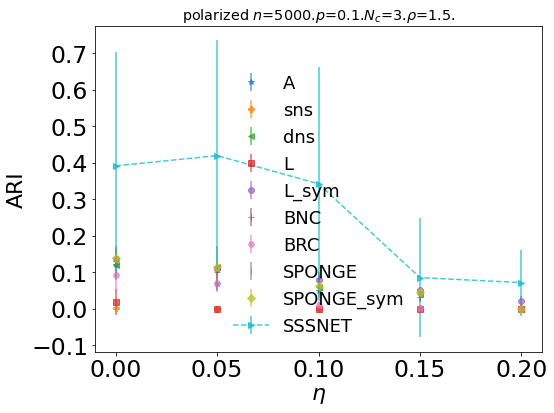

KandallTau results are [0.95555556 1.         0.68888889 0.68888889 0.68888889 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333] with mean 0.569 and standard deviation 0.256.
Saving figure!
Saving figure!


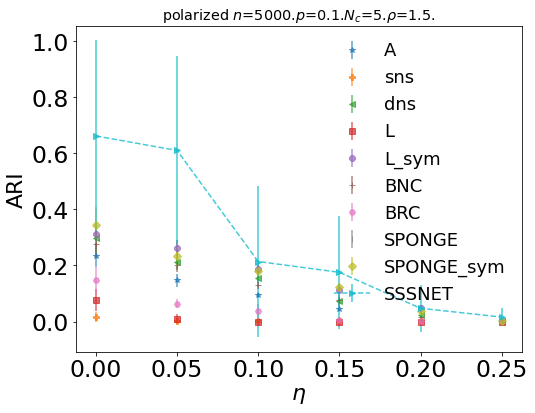

KandallTau results are [0.95555556 0.91111111 0.95555556 1.         0.91111111 0.95555556
 0.95555556 0.95555556 0.95555556 0.95555556] with mean 0.951 and standard deviation 0.024.
Saving figure!
Saving figure!


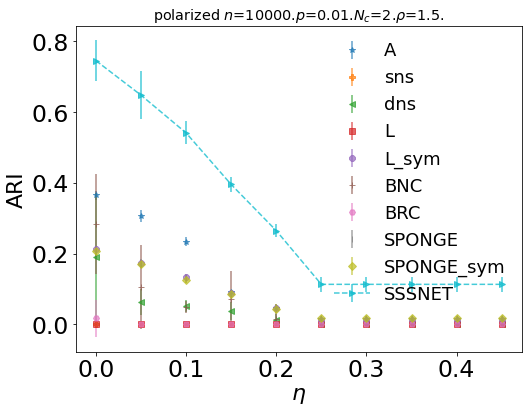

In [7]:
kendalltau_list.extend(polarized_comparison_plot(total_n=1050, num_com=2,K=2,p=0.1,eta=0.05,size_ratio=1,N=200))
kendalltau_list.extend(polarized_comparison_plot(total_n=5000, num_com=3,K=2,p=0.1,eta=0.05,size_ratio=1.5,N=500))
kendalltau_list.extend(polarized_comparison_plot(total_n=5000, num_com=5,K=2,p=0.1,eta=0.05,size_ratio=1.5,N=500))
kendalltau_list.extend(polarized_comparison_plot(total_n=10000, num_com=2,K=2,p=0.01,eta=0.05,size_ratio=1.5,N=2000))

In [8]:
ranking_kendalltau = np.array(kendalltau_list)
print('KandallTau results are {} with mean {:.3f} and standard deviation {:.3f}.'.format(ranking_kendalltau, 
                                                                                             np.nanmean(ranking_kendalltau), 
                                                                                             np.nanstd(ranking_kendalltau)))

KandallTau results are [0.95555556 0.86666667 1.         0.42222222 0.73333333 0.73333333
 1.         1.         1.         1.         1.         1.
 1.         0.91111111 1.         0.95555556 1.         0.91111111
 0.86666667 1.         1.         1.         1.         1.
 1.         0.95555556 0.95555556 0.95555556 0.91111111 1.
 0.95555556 0.95555556 0.91111111 0.91111111 0.95555556 0.6
 0.72727273 0.73333333 0.0952381  1.         1.         1.
 0.91111111 0.91111111 0.73333333 0.42222222 0.42222222 0.42222222
 0.42222222 0.42222222 0.95555556 0.82222222 1.         0.68888889
 0.55555556 0.55555556 0.55555556 0.55555556 0.55555556 0.55555556
 0.95555556 1.         0.68888889 0.68888889 0.68888889 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.95555556 0.91111111
 0.95555556 1.         0.91111111 0.95555556 0.95555556 0.95555556
 0.95555556 0.95555556] with mean 0.808 and standard deviation 0.233.


### Summary
This is a sample notebook to compare results on synthetic data.